In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

import re
from nltk import sent_tokenize

import scienceplots
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collections import defaultdict

plt.style.use('science')

# Constants 

In [2]:
MODEL_RES = '../results/'

In [3]:
formatters = {
    'model': '${}$\t',
    'dataset': '{}\t',
    'test_set': '${}$\t',
    '% valid': '{:.2f}\\%',
    'nll': '{:.2f}',
    'log_perp': '{:.2f}',
    'acc_1': '{:.2f}\\%',
    'acc_3': '{:.2f}\\%',
    'acc_5': '{:.2f}\\%',
    'top_1_sim': '{:.3f}',
    'top_3_sim': '{:.3f}',
    'top_5_sim': '{:.3f}',
    'macro_prec': '{:.2f}',
    'macro_rec': '{:.2f}',
    'macro_f1': '{:.2f}',
    'micro_prec': '{:.2f}',
    'micro_rec': '{:.2f}',
    'micro_f1': '{:.2f}'
}

In [4]:
metric_names = {
    'model': 'Model',
    'dataset': 'Dataset',
    'test_set': 'Test Set',
    '% valid': '% Valid',
    'nll': 'NLL\\downarrow',
    'log_perp': 'Log Perp\\downarrow',
    'macro_prec': 'P\\uparrow',
    'macro_rec': 'R\\uparrow', 
    'macro_f1': 'F1\\uparrow',
    'micro_prec': 'P\\uparrow',
    'micro_rec': 'R\\uparrow', 
    'micro_f1': 'F1\\uparrow',
    'acc_1': 'Acc@1\\uparrow', 
    'acc_3': 'Acc@3\\uparrow',
    'acc_5': 'Acc@5\\uparrow', 
    'top_1_sim': 'Sim@1\\uparrow', 
    'top_3_sim': 'Sim@3\\uparrow', 
    'top_5_sim': 'Sim@5\\uparrow'
}

In [5]:
formatters = {metric_names[k]: v for k,v in formatters.items()}

# MASIVE Evaluation (Table 4)

In [6]:
models = ['en_masive_t5_large', 
          'en_masive_mt5_large',
          'Meta-Llama-3-8B-Instruct_en',
          'mixtral-8x22b-instruct_en',          
          'es_masive_mt5_large',
          'Meta-Llama-3-8B-Instruct_es',
          'mixtral-8x22b-instruct_es']
model_names = ['T5^{En}', 
               'mT5^{En}', 
               'Llama-3', 
               'Mixtral', 
               'mT5^{Es}', 
               'Llama-3', 
               'Mixtral']

In [7]:
metrics = ['nll', 'log_perp', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
scale_metrics = ['acc_1', 'acc_3', 'acc_5']

In [8]:
all_scores = [pd.read_csv(f'{MODEL_RES}/{model}/internal/metrics.csv') for model in models]
all_scores = pd.concat(all_scores)
all_scores['Model'] = model_names
all_scores = all_scores[['Model'] + metrics]
all_scores[scale_metrics] = all_scores[scale_metrics]*100
all_scores = all_scores.rename(metric_names, axis = 1)

In [9]:
all_scores = all_scores.style.format(formatters).hide(axis=0)

In [10]:
print(all_scores.to_latex())

\begin{tabular}{lrrrrrrrr}
Model & NLL\downarrow & Log Perp\downarrow & Acc@1\uparrow & Acc@3\uparrow & Acc@5\uparrow & Sim@1\uparrow & Sim@3\uparrow & Sim@5\uparrow \\
$T5^{En}$	 & 6.87 & 6.85 & 20.05\% & 29.44\% & 34.64\% & 0.569 & 0.673 & 0.718 \\
$mT5^{En}$	 & 10.93 & 10.90 & 17.91\% & 26.81\% & 30.90\% & 0.564 & 0.670 & 0.711 \\
$Llama-3$	 & 60.79 & 44.84 & 1.29\% & 2.26\% & 2.92\% & 0.431 & 0.460 & 0.475 \\
$Mixtral$	 & 1.52 & nan & 7.83\% & 8.93\% & 10.55\% & 0.475 & 0.495 & 0.518 \\
$mT5^{Es}$	 & 6.91 & 6.89 & 24.51\% & 36.16\% & 41.23\% & 0.610 & 0.734 & 0.781 \\
$Llama-3$	 & 77.78 & 61.56 & 2.52\% & 4.69\% & 5.91\% & 0.445 & 0.480 & 0.498 \\
$Mixtral$	 & 1.47 & nan & 16.80\% & 19.47\% & 22.24\% & 0.525 & 0.553 & 0.583 \\
\end{tabular}



# External Eval (Table 5) 

In [11]:
models = ['mt5_large_goemo', 'en_masive_mt5_large_goemo',
          'mt5_large_goemo_full', 'en_masive_mt5_large_goemo_full',
          'mt5_large_emoevent_en', 'en_masive_mt5_large_emoevent_en',
          'mt5_large_emoevent_es', 'es_masive_mt5_large_emoevent_es'
         ]
model_names = ['mT5^{En}', 
               'mT5^{MAS}', 
               'mT5^{En}', 
               'mT5^{MAS}', 
               'mT5^{En}', 
               'mT5^{MAS}', 
               'mT5^{Es}', 
               'mT5^{MAS}']
dss    = ['goemo', 'goemo',
          'goemo_full', 'goemo_full',
          'emoevent_en', 'emoevent_en',
          'emoevent_es', 'emoevent_es'
         ]
ds_names = ['GoEmotions (7)', 'GoEmotions (7)',
            'GoEmotions (27)', 'GoEmotions (27)',
            'EmoEvent (En)', 'EmoEvent (En)',
            'EmoEvent (Es)', 'EmoEvent (Es)']

In [12]:
metrics = ['macro_prec', 'macro_rec', 'macro_f1', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
scale_metrics = ['macro_prec', 'macro_rec', 'macro_f1', 'acc_1', 'acc_3', 'acc_5']

In [13]:
all_scores = [pd.read_csv(f'{MODEL_RES}/{model}/external/{ds}/metrics.csv') for model, ds in zip(models, dss)]
all_scores = pd.concat(all_scores)
all_scores['model'] = model_names
all_scores['dataset'] = ds_names
all_scores = all_scores[['dataset', 'model'] + metrics]
all_scores[scale_metrics] = all_scores[scale_metrics]*100
all_scores = all_scores.rename(metric_names, axis = 1)

In [14]:
all_scores = all_scores.style.format(formatters).hide(axis=0)

In [15]:
print(all_scores.to_latex())

\begin{tabular}{llrrrrrrrrr}
Dataset & Model & P\uparrow & R\uparrow & F1\uparrow & Acc@1\uparrow & Acc@3\uparrow & Acc@5\uparrow & Sim@1\uparrow & Sim@3\uparrow & Sim@5\uparrow \\
GoEmotions (7)	 & $mT5^{En}$	 & 33.63 & 19.28 & 16.25 & 38.49\% & 70.73\% & 85.99\% & 0.736 & 0.884 & 0.946 \\
GoEmotions (7)	 & $mT5^{MAS}$	 & 33.06 & 39.81 & 28.30 & 17.49\% & 32.11\% & 39.25\% & 0.629 & 0.733 & 0.771 \\
GoEmotions (27)	 & $mT5^{En}$	 & 12.57 & 4.77 & 2.24 & 2.53\% & 12.90\% & 23.51\% & 0.525 & 0.614 & 0.670 \\
GoEmotions (27)	 & $mT5^{MAS}$	 & 27.08 & 18.76 & 11.92 & 7.54\% & 12.22\% & 15.16\% & 0.508 & 0.602 & 0.639 \\
EmoEvent (En)	 & $mT5^{En}$	 & 30.06 & 14.36 & 2.84 & 10.50\% & 71.70\% & 93.64\% & 0.630 & 0.880 & 0.974 \\
EmoEvent (En)	 & $mT5^{MAS}$	 & 34.81 & 32.74 & 29.55 & 33.40\% & 57.06\% & 69.38\% & 0.712 & 0.842 & 0.893 \\
EmoEvent (Es)	 & $mT5^{Es}$	 & 26.13 & 14.52 & 6.41 & 24.29\% & 70.34\% & 89.12\% & 0.713 & 0.882 & 0.955 \\
EmoEvent (Es)	 & $mT5^{MAS}$	 & 54.93 & 21.54 

# Unseen Affective States (Table 6) 

In [16]:
models = ['en_masive_t5_large', 
          'en_masive_mt5_large',         
          'es_masive_mt5_large']
model_names = ['T5^{En}', 
               'mT5^{En}', 
               'mT5^{Es}']
langs = ['En', 'En', 'Es']

In [17]:
metrics = ['nll', 'log_perp', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
scale_metrics = ['acc_1', 'acc_3', 'acc_5']

In [18]:
all_preds = [pd.read_csv(f'{MODEL_RES}/{model}/internal/preds.csv') for model in models]
en_test = pd.read_csv(f'../masive/en/test.csv')
es_test = pd.read_csv(f'../masive/es/test.csv')

In [19]:
all_preds = [pred.merge(en_test[['id', 'challenge']] if lang == 'En' else es_test[['id', 'challenge']], on = 'id') for pred, lang in zip(all_preds, langs)]

In [20]:
all_scores = defaultdict(list)
for pred, model_name, lang in zip(all_preds, model_names, langs):
    all_scores['lang'] += [lang] * 2
    all_scores['model'] += [model_name] * 2
    all_scores['subset'] += ['Seen', 'Unseen']
    
    challenge_sub = pred[pred['challenge']]
    nonchallenge_sub = pred[~pred['challenge']]
    for metric in metrics:
        all_scores[metric].append(nonchallenge_sub[metric].mean())
        all_scores[metric].append(challenge_sub[metric].mean())

In [21]:
all_scores = pd.DataFrame(all_scores)
all_scores[scale_metrics] = all_scores[scale_metrics]*100
all_scores = all_scores.rename(metric_names, axis = 1)

In [22]:
all_scores = all_scores.style.format(formatters).hide(axis=0)

In [23]:
print(all_scores.to_latex())

\begin{tabular}{lllrrrrrrrr}
lang & Model & subset & NLL\downarrow & Log Perp\downarrow & Acc@1\uparrow & Acc@3\uparrow & Acc@5\uparrow & Sim@1\uparrow & Sim@3\uparrow & Sim@5\uparrow \\
En & $T5^{En}$	 & Seen & 3.64 & 3.62 & 35.22\% & 50.31\% & 57.70\% & 0.640 & 0.756 & 0.805 \\
En & $T5^{En}$	 & Unseen & 10.52 & 10.49 & 2.92\% & 5.88\% & 8.61\% & 0.488 & 0.579 & 0.620 \\
En & $mT5^{En}$	 & Seen & 3.77 & 3.75 & 32.85\% & 48.90\% & 56.13\% & 0.633 & 0.757 & 0.804 \\
En & $mT5^{En}$	 & Unseen & 19.01 & 18.98 & 1.04\% & 1.88\% & 2.41\% & 0.487 & 0.571 & 0.607 \\
Es & $mT5^{Es}$	 & Seen & 3.36 & 3.34 & 37.89\% & 55.48\% & 62.63\% & 0.654 & 0.779 & 0.825 \\
Es & $mT5^{Es}$	 & Unseen & 13.09 & 13.07 & 1.18\% & 2.44\% & 3.88\% & 0.532 & 0.655 & 0.704 \\
\end{tabular}



# Regional Spanish Varieties (Table 7) 

In [24]:
models = ['es_masive_mt5_large',
          'Meta-Llama-3-8B-Instruct_es_reg',
          'mixtral-8x22b-instruct_es_reg'
         ]
model_names = ['mT5^{Es}',
               'Llama-3',
               'Mixtral'
              ]

In [25]:
metrics = ['nll', 'log_perp', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
scale_metrics = ['acc_1', 'acc_3', 'acc_5']

In [26]:
all_scores = [pd.read_csv(f'{MODEL_RES}/{model}/internal/regional/metrics.csv') for model in models]
all_scores = pd.concat(all_scores)
all_scores['model'] = model_names
all_scores = all_scores[['model'] + metrics]
all_scores[scale_metrics] = all_scores[scale_metrics]*100
all_scores = all_scores.rename(metric_names, axis = 1)

In [27]:
all_scores = all_scores.style.format(formatters).hide(axis=0)

In [28]:
print(all_scores.to_latex())

\begin{tabular}{lrrrrrrrr}
Model & NLL\downarrow & Log Perp\downarrow & Acc@1\uparrow & Acc@3\uparrow & Acc@5\uparrow & Sim@1\uparrow & Sim@3\uparrow & Sim@5\uparrow \\
$mT5^{Es}$	 & 12.31 & 12.31 & 14.07\% & 25.31\% & 31.37\% & 0.462 & 0.585 & 0.635 \\
$Llama-3$	 & 69.96 & 54.00 & 0.00\% & 0.00\% & 0.00\% & 0.376 & 0.408 & 0.416 \\
$Mixtral$	 & 1.55 & nan & 0.04\% & 0.16\% & 0.38\% & 0.342 & 0.358 & 0.372 \\
\end{tabular}



# Linguistic Constructions 

## Functions 

In [29]:
def get_gender(trg):
    trg = re.sub(r'\<extra_id_\d+\>|\<s\>|\</s\>|[^\w\s]+', '', trg).strip()
    labels = [t for t in trg.split(' ') if t != '']
    # print(labels)
    fem, masc = False, False
    for label in labels:
        if label[-1] == 'a' or label[-2:] == 'as':
            fem = True
        elif label[-1] == 'o' or label[-2:] == 'os':
            masc = True
    if fem:
        return 'fem'
    elif masc:
        return 'masc'
    else:
        return 'neut'

def gender_results(dfs, models):
    all_res = []
    for df, model in zip(dfs, models):
        df['gender'] = df['gold'].progress_apply(get_gender)
        df[metrics] = df[metrics].astype(float)
        df = df[df['log_perp'] != np.inf]
        for gender in ['fem', 'masc', 'neut']:
            sub_res = df[df['gender'] == gender][metrics].mean(skipna = True, numeric_only = True).to_dict()
            sub_res['gender'] = gender
            sub_res['model']  = model
            sub_res['size']   = len(df[df['gender'] == gender])

            all_res.append(sub_res)
    all_res = pd.DataFrame(all_res)
    all_res = all_res[['model', 'gender', 'size'] + all_res.columns[:-3].tolist()]
    return all_res

In [30]:
negs_en = r'\bnot\b|\bn\'t\b|\bno\b'
negs_es = r'\bno\b'
def is_negated(text, lang = 'en'):
    found_something = False
    for sent in sent_tokenize(text.replace('...', '_ELLIPSIS').replace('\n', ' ')):
        subsents = re.findall(r'.*(?=\<extra_id_\d+\>)', sent)
        if len(subsents) == 0:
            continue
        else:
            found_something = True
        
        if lang == 'en':
            for subsent in subsents:
                if len(re.findall(negs_en, subsent, re.IGNORECASE)) > 0:
                    return True
        elif lang == 'es':
            for subsent in subsents:
                if len(re.findall(negs_es, subsent, re.IGNORECASE)) > 0:
                    return True
    if not found_something:
        print('Uh oh')
        print(text)
        raise ValueError()
    return False

def negated_results(dfs, langs, models):
    all_res = []
    for df, lang, model in zip(dfs, langs, models):
        df['negated'] = df['input'].progress_apply(lambda t: is_negated(t, lang = lang))
        df = df[df['log_perp'] != np.inf]
        df[metrics] = df[metrics].astype(float)
        
        neg_res = df[df['negated']][metrics].astype(float).mean(skipna = True, numeric_only = True).to_dict()
        neg_res['neg'] = 'neg'
        neg_res['model'] = model
        neg_res['lang'] = lang
        neg_res['size'] = len(neg_res)
        
        nneg_res = df[~df['negated']][metrics].astype(float).mean(skipna = True, numeric_only = True).to_dict()
        nneg_res['neg'] = 'non_neg'
        nneg_res['model'] = model
        nneg_res['lang'] = lang
        nneg_res['size'] = len(nneg_res)
        
        all_res.append(neg_res)
        all_res.append(nneg_res)
    all_res = pd.DataFrame(all_res)
    all_res = all_res[['model', 'lang', 'neg', 'size'] + all_res.columns[:-4].tolist()]
    return all_res

## Negations 

In [31]:
BASE_DIR = '../results/'
models   = ['en_masive_t5_large', 
            'en_masive_mt5_large', 
            'Meta-Llama-3-8B-Instruct_en', 
            'mixtral-8x22b-instruct_en', 
            'es_masive_mt5_large', 
            'Meta-Llama-3-8B-Instruct_es', 
            'mixtral-8x22b-instruct_es']
model_names = ['T5', 
               'mT5', 
               'Llama-3', 
               'Mixtral', 
               'mT5', 
               'Llama-3', 
               'Mixtral']
all_preds = [pd.read_csv(BASE_DIR + model + '/internal/preds.csv') for model in models]
langs = ['en', 'en', 
         'en', 
         'en', 
         'es', 'es', 'es']

In [32]:
en = pd.read_csv('../masive/en/test.csv')
es = pd.read_csv('../masive/es/test.csv')

In [33]:
en['is_negated'] = en['input'].progress_apply(is_negated)
es['is_negated'] = es['input'].progress_apply(lambda t: is_negated(t, lang = 'es'))

  0%|          | 0/10049 [00:00<?, ?it/s]

  0%|          | 0/4274 [00:00<?, ?it/s]

In [34]:
for i, (pred, lang) in enumerate(zip(all_preds, langs)):
    if 'log_perp' not in pred.columns:
        all_preds[i]['log_perp'] = np.nan
    
    all_preds[i] = all_preds[i].dropna(subset = 'input').reset_index(drop = True)
    all_preds[i] = all_preds[i].drop('input', axis = 1)
    
    if lang == 'en':
        all_preds[i]['id'] = en['id']
        all_preds[i]['input'] = en['clip_input']
    elif lang == 'es':
        all_preds[i]['id'] = es['id']
        all_preds[i]['input'] = es['clip_input']

In [35]:
neg_res = negated_results(all_preds, langs, model_names)

  0%|          | 0/10049 [00:00<?, ?it/s]

  0%|          | 0/10049 [00:00<?, ?it/s]

  0%|          | 0/10049 [00:00<?, ?it/s]

  0%|          | 0/10049 [00:00<?, ?it/s]

  0%|          | 0/4274 [00:00<?, ?it/s]

  0%|          | 0/4274 [00:00<?, ?it/s]

  0%|          | 0/4274 [00:00<?, ?it/s]

In [36]:
metrics = ['nll', 'log_perp', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
mults   = [1, 1, 100, 100, 100, 1, 1, 1]
formats = ['{:.2f}', '{:.2f}', '{:.1f}\%', '{:.1f}\%', '{:.1f}\%', '{:.3f}', '{:.3f}', '{:.3f}']

In [37]:
for metric, mult, form in zip(metrics, mults, formats):
    neg_res[metric] = (neg_res[metric] * mult)
    neg_ress = neg_res.copy()
    neg_ress[metric] = neg_ress[metric].apply(form.format)

neg_ress = neg_ress[neg_ress['neg'] == 'neg']
neg_ress   = neg_ress[['lang', 'model'] + metrics]

In [38]:
print(neg_ress.style.to_latex())

\begin{tabular}{lllrrrrrrrl}
 & lang & model & nll & log_perp & acc_1 & acc_3 & acc_5 & top_1_sim & top_3_sim & top_5_sim \\
0 & en & T5 & 7.021792 & 6.939085 & 23.493388 & 35.422271 & 41.428761 & 0.592459 & 0.701751 & 0.748 \\
2 & en & mT5 & 11.526908 & 11.441400 & 20.554112 & 29.449398 & 33.573983 & 0.578598 & 0.682647 & 0.726 \\
4 & en & Llama-3 & 71.280807 & 55.169007 & 1.583548 & 2.187441 & 3.068592 & 0.420495 & 0.443581 & 0.459 \\
6 & en & Mixtral & 1.451405 & nan & 11.361852 & 13.056897 & 15.009365 & 0.486800 & 0.510497 & 0.534 \\
8 & es & mT5 & 7.277667 & 7.241091 & 23.755948 & 34.249311 & 38.982595 & 0.585466 & 0.712764 & 0.764 \\
10 & es & Llama-3 & 83.747276 & 67.414730 & 1.933383 & 3.428500 & 3.829201 & 0.426350 & 0.453944 & 0.468 \\
12 & es & Mixtral & 1.455457 & nan & 16.463186 & 18.997621 & 22.386677 & 0.506960 & 0.535194 & 0.572 \\
\end{tabular}



## Gender 

In [39]:
BASE_DIR = '../../results/model_res/'
models   = ['es_random_mt5_large', 'Meta-Llama-3-8B-Instruct_es', 'mixtral-8x22b-instruct_es']
model_names = ['mT5', 'Llama-3', 'Mixtral']
all_preds = [pd.read_csv(BASE_DIR + model + '/internal/preds.csv') for model in models]

In [40]:
for i, pred in enumerate(all_preds):
    if 'log_perp' not in pred.columns:
        all_preds[i]['log_perp'] = np.nan
        
    all_preds[i] = all_preds[i].dropna(subset = 'input').reset_index(drop = True)
    all_preds[i] = all_preds[i].drop('input', axis = 1)
    
    all_preds[i]['id'] = es['id']
    all_preds[i]['input'] = es['clip_input']

In [41]:
gend_res = gender_results(all_preds, model_names)

  0%|          | 0/6232 [00:00<?, ?it/s]

  0%|          | 0/6232 [00:00<?, ?it/s]

  0%|          | 0/6232 [00:00<?, ?it/s]

In [42]:
metrics = ['nll', 'log_perp', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
mults   = [1, 1, 100, 100, 100, 1, 1, 1]
formats = ['{:.2f}', '{:.2f}', '{:.1f}\%', '{:.1f}\%', '{:.1f}\%', '{:.3f}', '{:.3f}', '{:.3f}']

In [43]:
for metric, mult, form in zip(metrics, mults, formats):
    gend_res[metric] = (gend_res[metric] * mult)
    gend_ress = gend_res.copy()
    gend_ress[metric] = gend_ress[metric].apply(form.format)

gend_ress = gend_ress[gend_ress['gender'] != 'neut']
gend_ress   = gend_ress[['model', 'gender'] + metrics]

In [44]:
print(gend_ress.style.to_latex())

\begin{tabular}{lllrrrrrrrl}
 & model & gender & nll & log_perp & acc_1 & acc_3 & acc_5 & top_1_sim & top_3_sim & top_5_sim \\
0 & mT5 & fem & 6.825389 & 6.701535 & 22.051282 & 33.261577 & 38.987754 & 0.508657 & 0.605983 & 0.648 \\
1 & mT5 & masc & 7.277047 & 7.212709 & 19.431938 & 28.303274 & 32.709101 & 0.483373 & 0.587776 & 0.633 \\
3 & Llama-3 & fem & 87.057633 & 70.213367 & 1.769996 & 2.793724 & 3.013777 & 0.424480 & 0.459571 & 0.474 \\
4 & Llama-3 & masc & 80.789257 & 64.154791 & 2.453923 & 3.269265 & 3.831841 & 0.424952 & 0.456895 & 0.470 \\
6 & Mixtral & fem & 2.149643 & nan & 5.266935 & 6.823574 & 8.433519 & 0.445980 & 0.477995 & 0.504 \\
7 & Mixtral & masc & 1.932668 & nan & 8.704362 & 11.150386 & 12.929393 & 0.440988 & 0.473392 & 0.499 \\
\end{tabular}



## Plot 

In [45]:
plt.rcParams['figure.figsize'] = (10, 3)

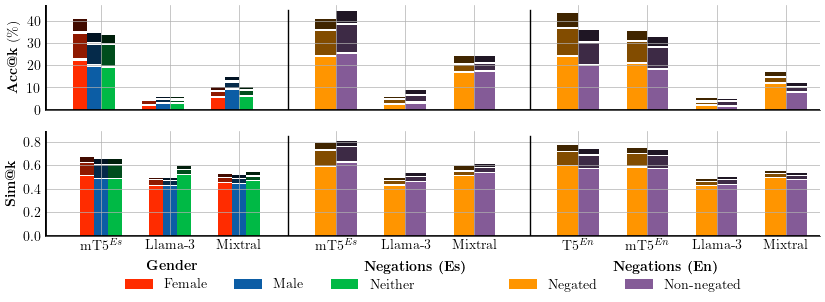

In [46]:
fig, axs = plt.subplots(2,1, sharex = True)
colors = [['C3', 'C7', 'C1', 'C2', 'C4'], ['#8f1900', '#052a4a', '#004d1c', '#824c00', '#3d2a45'], ['#420b00', '#021424', '#001f0b', '#402500', '#1f1624']]

# --- Gender Acc ---
width = 0.2
num_models = len(gend_res['gender'].unique())
for i, gender in enumerate(['fem', 'masc', 'neut']):
    sub = gend_res[gend_res['gender'] == gender]
    
    axs[0].bar(np.arange(num_models) + (i-1)*width, sub['acc_1'], width = width, label =  gender, color = colors[0][i])
    axs[0].bar(np.arange(num_models) + (i-1)*width, sub['acc_3'] - sub['acc_1'], bottom = sub['acc_1'] + 1, width = width, label =  gender, color = colors[1][i])
    axs[0].bar(np.arange(num_models) + (i-1)*width, sub['acc_5']-sub['acc_3'], bottom = sub['acc_3'] + 2, width = width, label =  gender, color = colors[2][i])

# --- Negations (Es) Acc ---
width = 0.3
offset = 3.5
axs[0].plot([2.8, 2.8], [0, 45], c = 'black')
        
sub_neg_res = neg_res[neg_res['lang'] == 'es']
num_models = len(sub_neg_res['model'].unique())
for i, neg in enumerate(['neg', 'non_neg']):
    sub = sub_neg_res[sub_neg_res['neg'] == neg]
    
    axs[0].bar(offset + np.arange(num_models) + (i-.5)*width, sub['acc_1'], width = width, label =  gender, color = colors[0][i+3])
    axs[0].bar(offset + np.arange(num_models) + (i-.5)*width, sub['acc_3'] - sub['acc_1'], bottom = sub['acc_1'] + 1, width = width, label =  gender, color = colors[1][i+3])
    axs[0].bar(offset + np.arange(num_models) + (i-.5)*width, sub['acc_5']-sub['acc_3'], bottom = sub['acc_3'] + 2, width = width, label =  gender, color = colors[2][i+3])

# --- Negations (En) Acc ---
offset = 7
axs[0].plot([6.3, 6.3], [0, 45], c = 'black')
        
sub_neg_res = neg_res[neg_res['lang'] == 'en']
num_models = len(sub_neg_res['model'].unique())
for i, neg in enumerate(['neg', 'non_neg']):
    sub = sub_neg_res[sub_neg_res['neg'] == neg]
    
    axs[0].bar(offset + np.arange(num_models) + (i-.5)*width, sub['acc_1'], width = width, label =  gender, color = colors[0][i+3])
    axs[0].bar(offset + np.arange(num_models) + (i-.5)*width, sub['acc_3'] - sub['acc_1'], bottom = sub['acc_1'] + 1, width = width, label =  gender, color = colors[1][i+3])
    axs[0].bar(offset + np.arange(num_models) + (i-.5)*width, sub['acc_5']-sub['acc_3'], bottom = sub['acc_3'] + 2, width = width, label =  gender, color = colors[2][i+3])
        
# --- Gender Sim ---
width = 0.2 
num_models = len(gend_res['model'].unique())
for i, gender in enumerate(['fem', 'masc', 'neut']):
    sub = gend_res[gend_res['gender'] == gender]
    
    axs[1].bar(np.arange(num_models) + (i-.5)*width, sub['top_1_sim'], width = width, label =  gender, color = colors[0][i])
    axs[1].bar(np.arange(num_models) + (i-.5)*width, sub['top_3_sim'] - sub['top_1_sim'], bottom = sub['top_1_sim'] + .01, width = width, label =  gender, color = colors[1][i])
    axs[1].bar(np.arange(num_models) + (i-.5)*width, sub['top_5_sim']-sub['top_3_sim'], bottom = sub['top_3_sim'] + .02, width = width, label =  gender, color = colors[2][i])

# --- Negations (Es) Acc ---
width = 0.3
offset = 3.5
plt.plot([2.8, 2.8], [0, .85], c = 'black')
        
sub_neg_res = neg_res[neg_res['lang'] == 'es']
num_models = len(sub_neg_res['model'].unique())      
for i, neg in enumerate(['neg', 'non_neg']):
    sub = sub_neg_res[sub_neg_res['neg'] == neg]
    
    axs[1].bar(offset + np.arange(num_models) + (i-.5)*width, sub['top_1_sim'], width = width, label =  gender, color = colors[0][i+3])
    axs[1].bar(offset + np.arange(num_models) + (i-.5)*width, sub['top_3_sim'] - sub['top_1_sim'], bottom = sub['top_1_sim'] + .01, width = width, label =  gender, color = colors[1][i+3])
    axs[1].bar(offset + np.arange(num_models) + (i-.5)*width, sub['top_5_sim']-sub['top_3_sim'], bottom = sub['top_3_sim'] + .02, width = width, label =  gender, color = colors[2][i+3])

# --- Negations (En) Acc ---
offset = 7
plt.plot([6.3, 6.3], [0, .85], c = 'black')
        
sub_neg_res = neg_res[neg_res['lang'] == 'en']
num_models = len(sub_neg_res['model'].unique())      
for i, neg in enumerate(['neg', 'non_neg']):
    sub = sub_neg_res[sub_neg_res['neg'] == neg]
    
    axs[1].bar(offset + np.arange(num_models) + (i-.5)*width, sub['top_1_sim'], width = width, label =  gender, color = colors[0][i+3])
    axs[1].bar(offset + np.arange(num_models) + (i-.5)*width, sub['top_3_sim'] - sub['top_1_sim'], bottom = sub['top_1_sim'] + .01, width = width, label =  gender, color = colors[1][i+3])
    axs[1].bar(offset + np.arange(num_models) + (i-.5)*width, sub['top_5_sim'] -sub['top_3_sim'], bottom = sub['top_3_sim'] + .02, width = width, label =  gender, color = colors[2][i+3])

# --- Legend ---
legend_names    = ['Female', 'Male', 'Neither', 'Negated', 'Non-negated']
legend_elements = [Patch(facecolor=color, label = name) for color, name in zip(colors[0], legend_names)]
legend_elements = legend_elements[:3] + [Patch(facecolor='#00000000', label = '')] + legend_elements[3:]

plt.legend(handles = legend_elements, loc = 'lower center', bbox_to_anchor = (0.5,  -0.65), ncol=6)

# --- Axes Labels ---
axs[0].set_ylabel(r'\textbf{Acc@k} (\%)')
axs[1].set_ylabel(r'\textbf{Sim@k}')
plt.xticks(np.array([0.1,1.1,2.1, 3.5, 1+3.5, 2+3.5, 7, 8, 9, 10]), 
           [r'mT5$^{Es}$', 'Llama-3', 'Mixtral', r'mT5$^{Es}$', 
            'Llama-3', 'Mixtral', r'T5$^{En}$', r'mT5$^{En}$', 'Llama-3', 'Mixtral'])

# Axes Ticks
axs[0].set_yticks(np.arange(5) * 10)
axs[1].set_yticks(np.arange(5) * 0.2)

# Experiment Labels
plt.text(.75, -.3, r'\textbf{Gender}')
plt.text(3.9, -.3, r'\textbf{Negations (Es)}')
plt.text(7.5, -.3, r'\textbf{Negations (En)}')

# --- Axis Visibility ---
axs[0].axhline(0, color = 'black', linewidth = 2)
axs[1].axhline(0, color = 'black', linewidth = 2)
axs[0].axvline(-.7, color = 'black', linewidth = 2)
axs[1].axvline(-.7, color = 'black', linewidth = 2)
axs[0].spines[['right', 'top']].set_visible(False)
axs[1].spines[['right', 'top']].set_visible(False)

# --- Grid Visibility ---
axs[0].grid(which = 'major', axis = 'y')
axs[1].grid(which = 'major', axis = 'y')
axs[0].grid(which = 'major', axis = 'x', visible = None) 
axs[1].grid(which = 'major', axis = 'x', visible = None)
axs[0].tick_params(which = 'both', top = False, left = False, right = False, bottom = False) 
axs[1].tick_params(which = 'both', top = False, left = False, right = False, bottom = False) 

# --- Limits
axs[0].set_xlim(-.7, 10.5)
axs[1].set_xlim(-.7, 10.5)

plt.savefig('../figures/linguistic_constructs.pdf', dpi = 600, bbox_inches = 'tight')

# Translation Experiments 

In [47]:
models = [
        'en_masive_sub0_mt5_large','en_masive_sub1_mt5_large', 'en_masive_sub2_mt5_large', 'en_masive_sub3_mt5_large', 'en_masive_sub4_mt5_large',
        'en_trans_masive_mt5_large',
        'es_masive_mt5_large',
        'es_masive_mt5_large',
        'es_trans_masive_sub0_mt5_large', 'es_trans_masive_sub1_mt5_large', 'es_trans_masive_sub2_mt5_large', 'es_trans_masive_sub3_mt5_large', 'es_trans_masive_sub4_mt5_large',
        'en_masive_sub0_mt5_large','en_masive_sub1_mt5_large', 'en_masive_sub2_mt5_large', 'en_masive_sub3_mt5_large', 'en_masive_sub4_mt5_large',
         ]
exps   = [
        'internal', 'internal', 'internal', 'internal', 'internal',
        'internal',
        'internal/trans',
        'internal',
        'internal', 'internal', 'internal', 'internal', 'internal',
        'internal/trans', 'internal/trans', 'internal/trans', 'internal/trans', 'internal/trans', 
         ]
model_groups = [0, 0, 0, 0, 0,
                1,
                2,
                3,
                4, 4, 4, 4, 4,
                5, 5, 5, 5, 5
               ]
model_names = ['mT5^{En}_S',
               'mT5^{En}_Tr',
               'mT5^{Es}',
               'mT5^{Es}',
               'mT5^{Es}_{Tr,S}',
               'mT5^{En}_S'
              ]
test_sets   = [
                'En', 
                'En',
                'Es_{Tr}', 
                'Es', 
                'Es', 
                'En_{Tr}'
              ]

In [48]:
metrics = ['nll', 'log_perp', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
scale_metrics = ['acc_1', 'acc_3', 'acc_5']

In [49]:
all_scores = [pd.read_csv(f'{MODEL_RES}/{model}/{exp}/metrics.csv') for model, exp in zip(models, exps)]
all_scores = pd.concat(all_scores)
all_scores['group'] = model_groups
all_scores = all_scores.groupby('group').mean().reset_index()
all_scores['model'] = model_names
all_scores['test_set'] = test_sets
all_scores = all_scores[['test_set', 'model'] + metrics]
all_scores[scale_metrics] = all_scores[scale_metrics]*100
all_scores = all_scores.rename(metric_names, axis = 1)

In [50]:
all_scores = all_scores.style.format(formatters).hide(axis=0)

In [51]:
print(all_scores.to_latex())

\begin{tabular}{llrrrrrrrr}
Test Set & Model & NLL\downarrow & Log Perp\downarrow & Acc@1\uparrow & Acc@3\uparrow & Acc@5\uparrow & Sim@1\uparrow & Sim@3\uparrow & Sim@5\uparrow \\
$En$	 & $mT5^{En}_S$	 & 4.21 & 4.17 & 27.05\% & 41.37\% & 48.71\% & 0.598 & 0.719 & 0.769 \\
$En$	 & $mT5^{En}_Tr$	 & 16.86 & 15.79 & 2.18\% & 4.45\% & 6.12\% & 0.418 & 0.532 & 0.579 \\
$Es_{Tr}$	 & $mT5^{Es}$	 & 59.37 & 59.23 & 2.35\% & 4.20\% & 5.46\% & 0.369 & 0.448 & 0.482 \\
$Es$	 & $mT5^{Es}$	 & 6.91 & 6.89 & 24.51\% & 36.16\% & 41.23\% & 0.610 & 0.734 & 0.781 \\
$Es$	 & $mT5^{Es}_{Tr,S}$	 & 15.80 & 15.54 & 2.37\% & 4.95\% & 6.58\% & 0.378 & 0.472 & 0.517 \\
$En_{Tr}$	 & $mT5^{En}_S$	 & 24.15 & 23.94 & 3.07\% & 6.60\% & 9.39\% & 0.443 & 0.532 & 0.573 \\
\end{tabular}



# Appendices 

## Llama Re-analysis 

In [52]:
def check_format(pred):
    expected_reg = r'\b(\w+,\s*)+\w+\b'
    return re.fullmatch(expected_reg, pred) is not None

def filter_preds(preds):
    preds['valid_format'] = preds['pred'].progress_apply(check_format)
    valid_preds = preds[preds['valid_format']]
    return valid_preds

In [53]:
models = [
          'Meta-Llama-3-8B-Instruct_en',
          'Meta-Llama-3-8B-Instruct_es',
          'Meta-Llama-3-8B-Instruct_es_reg'
         ]
exps = ['internal', 'internal', 'internal/regional']
langs = ['En', 'Es', 'Es (Reg)']

In [54]:
metrics = ['nll', 'log_perp', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
scale_metrics = ['acc_1', 'acc_3', 'acc_5', '% valid']

In [55]:
all_preds = [pd.read_csv(f'{MODEL_RES}/{model}/{exp}/preds.csv') for model, exp in zip(models, exps)]
valid_preds = [filter_preds(pred) for pred in all_preds]
all_scores = [{metric: pred[metric].mean() for metric in metrics} for pred in valid_preds]
for i, scores in enumerate(all_scores):
    all_scores[i]['% valid'] = len(valid_preds[i])/len(all_preds[i])

  0%|          | 0/10049 [00:00<?, ?it/s]

  0%|          | 0/4274 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

In [56]:
all_scores = pd.DataFrame(all_scores)
all_scores['lang'] = langs
all_scores = all_scores[['lang', '% valid'] + metrics]
all_scores[scale_metrics] = all_scores[scale_metrics]*100
all_scores = all_scores.rename(metric_names, axis = 1)

In [57]:
all_scores = all_scores.style.format(formatters).hide(axis=0)

In [58]:
print(all_scores.to_latex())

\begin{tabular}{lrrrrrrrrr}
lang & % Valid & NLL\downarrow & Log Perp\downarrow & Acc@1\uparrow & Acc@3\uparrow & Acc@5\uparrow & Sim@1\uparrow & Sim@3\uparrow & Sim@5\uparrow \\
En & 59.69\% & 63.23 & 47.09 & 2.05\% & 3.63\% & 4.69\% & 0.433 & 0.479 & 0.502 \\
Es & 69.51\% & 79.01 & 62.83 & 3.53\% & 6.57\% & 8.27\% & 0.467 & 0.516 & 0.541 \\
Es (Reg) & 76.03\% & 70.26 & 54.27 & 0.00\% & 0.00\% & 0.00\% & 0.384 & 0.425 & 0.436 \\
\end{tabular}



In [59]:
all_scores

lang,% Valid,NLL\downarrow,Log Perp\downarrow,Acc@1\uparrow,Acc@3\uparrow,Acc@5\uparrow,Sim@1\uparrow,Sim@3\uparrow,Sim@5\uparrow
En,59.69\%,63.23,47.09,2.05\%,3.63\%,4.69\%,0.433,0.479,0.502
Es,69.51\%,79.01,62.83,3.53\%,6.57\%,8.27\%,0.467,0.516,0.541
Es (Reg),76.03\%,70.26,54.27,0.00\%,0.00\%,0.00\%,0.384,0.425,0.436


## T5 External Results 

In [60]:
models = ['t5_large_goemo', 'en_masive_t5_large_goemo', 'mt5_large_goemo', 'en_masive_mt5_large_goemo',
          't5_large_goemo_full', 'en_masive_t5_large_goemo_full', 'mt5_large_goemo_full', 'en_masive_mt5_large_goemo_full',
          't5_large_emoevent_en', 'en_masive_t5_large_emoevent_en', 'mt5_large_emoevent_en', 'en_masive_mt5_large_emoevent_en',
          'mt5_large_emoevent_es', 'es_masive_mt5_large_emoevent_es'
         ]
model_names = ['T5^{En}', 
               'T5^{MAS}', 
               'mT5^{En}', 
               'mT5^{MAS}',
               'T5^{En}', 
               'T5^{MAS}', 
               'mT5^{En}', 
               'mT5^{MAS}',
               'T5^{En}', 
               'T5^{MAS}', 
               'mT5^{En}', 
               'mT5^{MAS}', 
               'mT5^{Es}', 
               'mT5^{MAS}']
dss    = ['goemo', 'goemo', 'goemo', 'goemo',
          'goemo_full', 'goemo_full', 'goemo_full', 'goemo_full',
          'emoevent_en', 'emoevent_en', 'emoevent_en', 'emoevent_en',
          'emoevent_es', 'emoevent_es'
         ]
ds_names = ['GoEmotions (7)', 'GoEmotions (7)', 'GoEmotions (7)', 'GoEmotions (7)',
            'GoEmotions (27)', 'GoEmotions (27)', 'GoEmotions (27)', 'GoEmotions (27)',
            'EmoEvent (En)', 'EmoEvent (En)', 'EmoEvent (En)', 'EmoEvent (En)',
            'EmoEvent (Es)', 'EmoEvent (Es)'
           ]

In [61]:
metrics = ['macro_prec', 'macro_rec', 'macro_f1', 'acc_1', 'acc_3', 'acc_5', 'top_1_sim', 'top_3_sim', 'top_5_sim']
scale_metrics = ['macro_prec', 'macro_rec', 'macro_f1', 'acc_1', 'acc_3', 'acc_5']

In [62]:
all_scores = [pd.read_csv(f'{MODEL_RES}/{model}/external/{ds}/metrics.csv') for model, ds in zip(models, dss)]
all_scores = pd.concat(all_scores)
all_scores['model'] = model_names
all_scores['dataset'] = ds_names
all_scores = all_scores[['dataset', 'model'] + metrics]
all_scores[scale_metrics] = all_scores[scale_metrics]*100
all_scores = all_scores.rename(metric_names, axis = 1)

In [63]:
all_scores = all_scores.style.format(formatters).hide(axis=0)

In [64]:
print(all_scores.to_latex())

\begin{tabular}{llrrrrrrrrr}
Dataset & Model & P\uparrow & R\uparrow & F1\uparrow & Acc@1\uparrow & Acc@3\uparrow & Acc@5\uparrow & Sim@1\uparrow & Sim@3\uparrow & Sim@5\uparrow \\
GoEmotions (7)	 & $T5^{En}$	 & 42.45 & 39.59 & 25.59 & 38.53\% & 47.95\% & 55.74\% & 0.734 & 0.775 & 0.804 \\
GoEmotions (7)	 & $T5^{MAS}$	 & 26.75 & 38.47 & 26.14 & 34.50\% & 47.26\% & 55.09\% & 0.708 & 0.774 & 0.803 \\
GoEmotions (7)	 & $mT5^{En}$	 & 33.63 & 19.28 & 16.25 & 38.49\% & 70.73\% & 85.99\% & 0.736 & 0.884 & 0.946 \\
GoEmotions (7)	 & $mT5^{MAS}$	 & 33.06 & 39.81 & 28.30 & 17.49\% & 32.11\% & 39.25\% & 0.629 & 0.733 & 0.771 \\
GoEmotions (27)	 & $T5^{En}$	 & 24.23 & 7.36 & 5.67 & 2.03\% & 3.27\% & 3.86\% & 0.197 & 0.461 & 0.492 \\
GoEmotions (27)	 & $T5^{MAS}$	 & 11.34 & 2.77 & 0.80 & 2.64\% & 4.10\% & 5.14\% & 0.506 & 0.560 & 0.574 \\
GoEmotions (27)	 & $mT5^{En}$	 & 12.57 & 4.77 & 2.24 & 2.53\% & 12.90\% & 23.51\% & 0.525 & 0.614 & 0.670 \\
GoEmotions (27)	 & $mT5^{MAS}$	 & 27.08 & 18.76 & 11.